<a href="https://colab.research.google.com/github/Akashsky123/Deep-Learning-Lab/blob/main/Experiment_7_Transformer_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 7: Sequence-to-Sequence Learning with Transformers
### English → Spanish Neural Machine Translation

This notebook implements a complete Transformer-based Encoder-Decoder model for English-to-Spanish translation, including:
- Embedding Layer
- Sinusoidal Positional Encoding
- Multi-Head Self-Attention
- Transformer Encoder & Decoder
- Training with Teacher Forcing
- BLEU Score Evaluation

## Cell 1: Install Dependencies

In [1]:
# Install required libraries
!pip install torch torchtext sacrebleu -q
!pip install sacrebleu -q

print(" Dependencies installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 12.7 MB/s eta 0:00:00
 Dependencies installed successfully!


## Cell 2: Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import math
import time
import random
import numpy as np
import re
import unicodedata
from collections import Counter
from urllib.request import urlretrieve
import zipfile
import os

import sacrebleu
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

 Using device: cuda
PyTorch version: 2.10.0+cu128


## Cell 3: Download Dataset (Tatoeba English-Spanish)

In [6]:
# Download Tatoeba English-Spanish dataset (from Anki)
URL = "https://www.manythings.org/anki/spa-eng.zip"
ZIP_FILE = "spa-eng.zip"
DATA_FILE = "spa.txt"

# Import urllib.request and shutil
import urllib.request
import shutil

if not os.path.exists(DATA_FILE):
    print("Downloading dataset...")
    # Create a Request object with a User-Agent header to mimic a common browser
    req = urllib.request.Request(URL, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'})
    # Use urlopen to get the response and shutil to save the file
    with urllib.request.urlopen(req) as response, open(ZIP_FILE, 'wb') as out_file:
        shutil.copyfileobj(response, out_file);

    with zipfile.ZipFile(ZIP_FILE, 'r') as z:
        z.extract('spa.txt', '.')
    print(" Dataset downloaded and extracted!")
else:
    print(" Dataset already exists.")

# Peek at the file
with open(DATA_FILE, 'r', encoding='utf-8') as f:
    lines = f.readlines()

print(f"Total sentence pairs: {len(lines)}")
print("\nSample pairs:")
for line in lines[:5]:
    parts = line.strip().split('\t')
    print(f"  EN: {parts[0]}  →  ES: {parts[1]}")

 Dataset downloaded and extracted!
Total sentence pairs: 144215

Sample pairs:
  EN: Go.  →  ES: Ve.
  EN: Go.  →  ES: Vete.
  EN: Go.  →  ES: Vaya.
  EN: Go.  →  ES: Váyase.
  EN: Go.  →  ES: Id.


## Cell 4: Preprocessing & Vocabulary Building

In [7]:
# ─────────────────────────────────────────
#  Special tokens
# ─────────────────────────────────────────
PAD_TOKEN = '<pad>'
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'
UNK_TOKEN = '<unk>'

PAD_IDX = 0
SOS_IDX = 1
EOS_IDX = 2
UNK_IDX = 3

def normalize_string(s):
    """Unicode normalize, lowercase, remove non-letter chars except basic punctuation."""
    s = s.lower().strip()
    # Normalize unicode accents
    s = ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
    # Space out punctuation
    s = re.sub(r"([.!?¿¡])", r" \1", s)
    # Remove non-letter/punct chars
    s = re.sub(r"[^a-zA-Z.!?¿¡]+", r" ", s)
    return s.strip()

def tokenize(s):
    return normalize_string(s).split()


class Vocabulary:
    def __init__(self):
        self.word2idx = {PAD_TOKEN: PAD_IDX, SOS_TOKEN: SOS_IDX,
                        EOS_TOKEN: EOS_IDX, UNK_TOKEN: UNK_IDX}
        self.idx2word = {v: k for k, v in self.word2idx.items()}
        self.freq = Counter()

    def build(self, sentences, min_freq=2):
        for sent in sentences:
            self.freq.update(sent)
        for word, count in self.freq.items():
            if count >= min_freq and word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word
        print(f"  Vocabulary size: {len(self.word2idx)}")

    def encode(self, tokens):
        return [self.word2idx.get(t, UNK_IDX) for t in tokens]

    def decode(self, indices):
        return [self.idx2word.get(i, UNK_TOKEN) for i in indices]

    def __len__(self):
        return len(self.word2idx)


# ─────────────────────────────────────────
#  Load & sample dataset
# ─────────────────────────────────────────
MAX_LEN   = 20    # max tokens per sentence
MAX_PAIRS = 10000 # use 10k pairs for speed

pairs = []
with open(DATA_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) < 2:
            continue
        en_tok = tokenize(parts[0])
        es_tok = tokenize(parts[1])
        if 1 <= len(en_tok) <= MAX_LEN and 1 <= len(es_tok) <= MAX_LEN:
            pairs.append((en_tok, es_tok))

random.shuffle(pairs)
pairs = pairs[:MAX_PAIRS]
print(f"Filtered & sampled pairs: {len(pairs)}")

# 80 / 10 / 10 split
n = len(pairs)
train_pairs = pairs[:int(0.8*n)]
val_pairs   = pairs[int(0.8*n):int(0.9*n)]
test_pairs  = pairs[int(0.9*n):]
print(f"Train: {len(train_pairs)}  Val: {len(val_pairs)}  Test: {len(test_pairs)}")

# Build vocabularies on train set only
en_vocab = Vocabulary()
es_vocab = Vocabulary()
print("\nBuilding English vocab:")
en_vocab.build([p[0] for p in train_pairs], min_freq=2)
print("Building Spanish vocab:")
es_vocab.build([p[1] for p in train_pairs], min_freq=2)

Filtered & sampled pairs: 10000
Train: 8000  Val: 1000  Test: 1000

Building English vocab:
  Vocabulary size: 2258
Building Spanish vocab:
  Vocabulary size: 2902


## Cell 5: Dataset & DataLoader

In [9]:
class TranslationDataset(Dataset):
    def __init__(self, pairs, src_vocab, tgt_vocab):
        self.pairs = pairs
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src_tok, tgt_tok = self.pairs[idx]
        src = self.src_vocab.encode(src_tok)
        tgt = self.tgt_vocab.encode(tgt_tok)
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)


def collate_fn(batch):
    """Pad to max length in batch and prepend SOS / append EOS to target."""
    srcs, tgts = zip(*batch)
    # Pad source
    src_padded = nn.utils.rnn.pad_sequence(srcs, batch_first=True,
                                            padding_value=PAD_IDX)
    # Prepend SOS and append EOS to target
    tgts_with_tokens = [
        torch.cat([torch.tensor([SOS_IDX]), t, torch.tensor([EOS_IDX])])
        for t in tgts
    ]
    tgt_padded = nn.utils.rnn.pad_sequence(tgts_with_tokens, batch_first=True,
                                            padding_value=PAD_IDX)
    return src_padded, tgt_padded


BATCH_SIZE = 64

train_ds = TranslationDataset(train_pairs, en_vocab, es_vocab)
val_ds   = TranslationDataset(val_pairs,   en_vocab, es_vocab)
test_ds  = TranslationDataset(test_pairs,  en_vocab, es_vocab)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print(f" DataLoaders created!")
print(f"Train batches: {len(train_loader)},  Val batches: {len(val_loader)},  Test batches: {len(test_loader)}")

# Show one batch
src_b, tgt_b = next(iter(train_loader))
print(f"\nSample batch → src shape: {src_b.shape}, tgt shape: {tgt_b.shape}")

 DataLoaders created!
Train batches: 125,  Val batches: 16,  Test batches: 16

Sample batch → src shape: torch.Size([64, 20]), tgt shape: torch.Size([64, 19])


## Cell 6: Positional Encoding

 PositionalEncoding output shape: torch.Size([2, 10, 16])  (expected: [2, 10, 16])


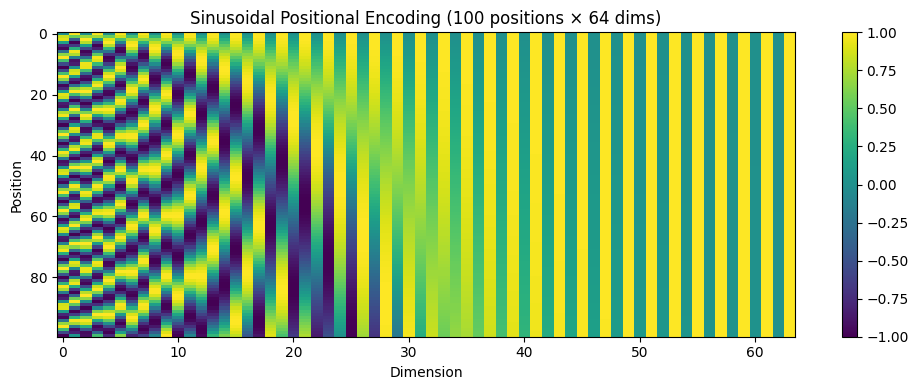

In [10]:
class PositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding from 'Attention Is All You Need'.

    PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
    PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Build PE matrix  [max_len, d_model]
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)   # [max_len, 1]
        div_term = torch.exp(
            torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)   # even dimensions
        pe[:, 1::2] = torch.cos(position * div_term)   # odd  dimensions
        pe = pe.unsqueeze(0)                            # [1, max_len, d_model]
        self.register_buffer('pe', pe)                 # not a parameter

    def forward(self, x):
        """
        x: [batch, seq_len, d_model]
        """
        x = x + self.pe[:, :x.size(1), :]  # broadcast over batch
        return self.dropout(x)


# Quick sanity check
pe_test = PositionalEncoding(d_model=16, max_len=50)
dummy = torch.zeros(2, 10, 16)
out = pe_test(dummy)
print(f" PositionalEncoding output shape: {out.shape}  (expected: [2, 10, 16])")

# Visualize
pe_vis = PositionalEncoding(d_model=64, max_len=100, dropout=0.0)
x_vis = torch.zeros(1, 100, 64)
pe_matrix = pe_vis(x_vis).squeeze(0).detach().numpy()
plt.figure(figsize=(10, 4))
plt.imshow(pe_matrix, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Sinusoidal Positional Encoding (100 positions × 64 dims)')
plt.xlabel('Dimension')
plt.ylabel('Position')
plt.tight_layout()
plt.show()

## Cell 7: Scaled Dot-Product Attention & Multi-Head Attention

In [11]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute Scaled Dot-Product Attention.

    Args:
        Q:    [batch, heads, seq_q, d_k]
        K:    [batch, heads, seq_k, d_k]
        V:    [batch, heads, seq_k, d_v]
        mask: [batch, 1, 1, seq_k]  (padding) or [batch, 1, seq_q, seq_k] (causal)

    Returns:
        context: [batch, heads, seq_q, d_v]
        attn_weights: [batch, heads, seq_q, seq_k]
    """
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)  # [b, h, q, k]

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    attn_weights = F.softmax(scores, dim=-1)                         # [b, h, q, k]
    context = torch.matmul(attn_weights, V)                          # [b, h, q, d_v]
    return context, attn_weights


class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention from 'Attention Is All You Need'.
    """
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model   = d_model
        self.num_heads = num_heads
        self.d_k       = d_model // num_heads  # dim per head

        self.W_q   = nn.Linear(d_model, d_model)  # query projection
        self.W_k   = nn.Linear(d_model, d_model)  # key   projection
        self.W_v   = nn.Linear(d_model, d_model)  # value projection
        self.W_out = nn.Linear(d_model, d_model)  # output projection

        self.dropout = nn.Dropout(dropout)

    def split_heads(self, x):
        """[batch, seq, d_model] → [batch, heads, seq, d_k]"""
        B, S, _ = x.size()
        return x.view(B, S, self.num_heads, self.d_k).transpose(1, 2)

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: [batch, seq, d_model]
        """
        Q = self.split_heads(self.W_q(query))   # [b, h, q, d_k]
        K = self.split_heads(self.W_k(key))
        V = self.split_heads(self.W_v(value))

        context, _ = scaled_dot_product_attention(Q, K, V, mask)  # [b, h, q, d_k]

        # Concatenate heads
        B, _, S, _ = context.size()
        context = context.transpose(1, 2).contiguous().view(B, S, self.d_model)

        return self.dropout(self.W_out(context))  # [b, q, d_model]


# Sanity check
mha = MultiHeadAttention(d_model=128, num_heads=8)
q = k = v = torch.rand(2, 10, 128)
out = mha(q, k, v)
print(f" MultiHeadAttention output shape: {out.shape}  (expected: [2, 10, 128])")

 MultiHeadAttention output shape: torch.Size([2, 10, 128])  (expected: [2, 10, 128])


## Cell 8: Position-wise Feed Forward Network

In [12]:
class PositionWiseFeedForward(nn.Module):
    """
    Two-layer FFN with ReLU: FFN(x) = max(0, xW1 + b1)W2 + b2
    """
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.fc1     = nn.Linear(d_model, d_ff)
        self.fc2     = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.fc2(self.dropout(F.relu(self.fc1(x))))


# Test
ffn = PositionWiseFeedForward(d_model=128, d_ff=512)
x = torch.rand(2, 10, 128)
print(f" FFN output shape: {ffn(x).shape}  (expected: [2, 10, 128])")

 FFN output shape: torch.Size([2, 10, 128])  (expected: [2, 10, 128])


## Cell 9: Transformer Encoder Layer & Encoder

In [13]:
class EncoderLayer(nn.Module):
    """
    One Transformer encoder layer:
        x → LayerNorm(x + MultiHeadSelfAttention(x))
          → LayerNorm(x + FFN(x))
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn  = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn        = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm1      = nn.LayerNorm(d_model)
        self.norm2      = nn.LayerNorm(d_model)
        self.dropout    = nn.Dropout(dropout)

    def forward(self, x, src_mask):
        # Sub-layer 1: Multi-head self-attention + residual + LayerNorm
        attn_out = self.self_attn(x, x, x, src_mask)
        x = self.norm1(x + self.dropout(attn_out))

        # Sub-layer 2: FFN + residual + LayerNorm
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))
        return x


class Encoder(nn.Module):
    """
    Full Transformer Encoder:
        Embedding + PositionalEncoding → N × EncoderLayer
    """
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers,
                 max_len=512, dropout=0.1):
        super().__init__()
        self.embedding  = nn.Embedding(vocab_size, d_model, padding_idx=PAD_IDX)
        self.pos_enc    = PositionalEncoding(d_model, max_len, dropout)
        self.layers     = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.scale      = math.sqrt(d_model)

    def forward(self, src, src_mask):
        """
        src:      [batch, src_len]
        src_mask: [batch, 1, 1, src_len]
        """
        x = self.embedding(src) * self.scale   # scale embeddings
        x = self.pos_enc(x)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x   # [batch, src_len, d_model]


print(" EncoderLayer and Encoder classes defined.")

 EncoderLayer and Encoder classes defined.


## Cell 10: Transformer Decoder Layer & Decoder

In [14]:
class DecoderLayer(nn.Module):
    """
    One Transformer decoder layer:
        x → LayerNorm(x + MaskedMultiHeadSelfAttention(x))   [causal]
          → LayerNorm(x + MultiHeadCrossAttention(x, enc))   [encoder-decoder]
          → LayerNorm(x + FFN(x))
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn  = MultiHeadAttention(d_model, num_heads, dropout)   # masked self-attn
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)   # encoder-decoder attn
        self.ffn        = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm1      = nn.LayerNorm(d_model)
        self.norm2      = nn.LayerNorm(d_model)
        self.norm3      = nn.LayerNorm(d_model)
        self.dropout    = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, tgt_mask):
        """
        x:        [batch, tgt_len, d_model]
        enc_out:  [batch, src_len, d_model]
        src_mask: [batch, 1, 1, src_len]            padding mask
        tgt_mask: [batch, 1, tgt_len, tgt_len]     causal mask
        """
        # 1. Masked self-attention (causal)
        sa_out = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(sa_out))

        # 2. Cross attention over encoder output
        ca_out = self.cross_attn(x, enc_out, enc_out, src_mask)
        x = self.norm2(x + self.dropout(ca_out))

        # 3. FFN
        ffn_out = self.ffn(x)
        x = self.norm3(x + self.dropout(ffn_out))
        return x


class Decoder(nn.Module):
    """
    Full Transformer Decoder:
        Embedding + PositionalEncoding → N × DecoderLayer → Linear projection
    """
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers,
                 max_len=512, dropout=0.1):
        super().__init__()
        self.embedding  = nn.Embedding(vocab_size, d_model, padding_idx=PAD_IDX)
        self.pos_enc    = PositionalEncoding(d_model, max_len, dropout)
        self.layers     = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.fc_out     = nn.Linear(d_model, vocab_size)  # projection to vocab
        self.scale      = math.sqrt(d_model)

    def forward(self, tgt, enc_out, src_mask, tgt_mask):
        """
        tgt:      [batch, tgt_len]
        enc_out:  [batch, src_len, d_model]
        """
        x = self.embedding(tgt) * self.scale
        x = self.pos_enc(x)
        for layer in self.layers:
            x = layer(x, enc_out, src_mask, tgt_mask)
        return self.fc_out(x)   # [batch, tgt_len, vocab_size]


print(" DecoderLayer and Decoder classes defined.")

 DecoderLayer and Decoder classes defined.


## Cell 11: Full Transformer Model & Mask Helpers

In [15]:
def make_src_mask(src):
    """
    Padding mask for encoder.
    src: [batch, src_len]
    Returns: [batch, 1, 1, src_len]  (1 = keep, 0 = ignore)
    """
    return (src != PAD_IDX).unsqueeze(1).unsqueeze(2)   # [b, 1, 1, src_len]


def make_tgt_mask(tgt):
    """
    Combined padding + causal mask for decoder.
    tgt: [batch, tgt_len]
    Returns: [batch, 1, tgt_len, tgt_len]
    """
    T = tgt.size(1)
    pad_mask  = (tgt != PAD_IDX).unsqueeze(1).unsqueeze(2)    # [b, 1, 1, T]
    causal    = torch.tril(torch.ones(T, T, device=tgt.device)).bool().unsqueeze(0).unsqueeze(0)  # [1,1,T,T]
    return pad_mask & causal   # [b, 1, T, T]


class Transformer(nn.Module):
    def __init__(self,
                 src_vocab_size, tgt_vocab_size,
                 d_model=256, num_heads=8,
                 d_ff=512,    num_layers=3,
                 max_len=512, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_heads, d_ff,
                                num_layers, max_len, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_heads, d_ff,
                                num_layers, max_len, dropout)

    def forward(self, src, tgt):
        src_mask = make_src_mask(src).to(src.device)
        tgt_mask = make_tgt_mask(tgt).to(tgt.device)

        enc_out  = self.encoder(src, src_mask)            # [b, src_len, d_model]
        output   = self.decoder(tgt, enc_out, src_mask, tgt_mask)  # [b, tgt_len, vocab]
        return output


# ─────────────────────────────────────────
#  Hyperparameters
# ─────────────────────────────────────────
D_MODEL    = 256
NUM_HEADS  = 8
D_FF       = 512
NUM_LAYERS = 3
DROPOUT    = 0.1
MAX_LEN_MODEL = 100

model = Transformer(
    src_vocab_size=len(en_vocab),
    tgt_vocab_size=len(es_vocab),
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    d_ff=D_FF,
    num_layers=NUM_LAYERS,
    max_len=MAX_LEN_MODEL,
    dropout=DROPOUT
).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"   Transformer model built!")
print(f"   Total trainable parameters: {total_params:,}")
print(f"   d_model={D_MODEL}, heads={NUM_HEADS}, d_ff={D_FF}, layers={NUM_LAYERS}")
print(f"   Encoder vocab: {len(en_vocab)},  Decoder vocab: {len(es_vocab)}")

   Transformer model built!
   Total trainable parameters: 6,020,438
   d_model=256, heads=8, d_ff=512, layers=3
   Encoder vocab: 2258,  Decoder vocab: 2902


## Cell 12: Weight Initialization & Optimizer

In [16]:
def initialize_weights(m):
    """Xavier uniform initialization for linear layers."""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, mean=0, std=D_MODEL**-0.5)
        m.weight.data[PAD_IDX] = 0.0  # keep PAD embedding zero

model.apply(initialize_weights)
print(" Weights initialized with Xavier uniform.")

# Adam optimizer with label smoothing cross-entropy
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)

# Loss: ignore PAD index
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1)

print(" Optimizer (Adam) and Loss (CrossEntropy + label smoothing) configured.")

 Weights initialized with Xavier uniform.
 Optimizer (Adam) and Loss (CrossEntropy + label smoothing) configured.


## Cell 13: Training & Validation Functions

In [17]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, n_batches = 0.0, 0

    for src, tgt in loader:
        src = src.to(device)   # [b, src_len]
        tgt = tgt.to(device)   # [b, tgt_len]  (includes SOS and EOS)

        # Teacher forcing: feed tgt[:-1] as input, predict tgt[1:]
        tgt_in  = tgt[:, :-1]  # [b, T-1]  — starts with SOS
        tgt_out = tgt[:, 1:]   # [b, T-1]  — ends with EOS

        # Forward pass
        logits = model(src, tgt_in)   # [b, T-1, vocab]

        # Flatten for cross-entropy
        B, T, V = logits.shape
        loss = criterion(logits.reshape(B*T, V), tgt_out.reshape(B*T))

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # gradient clipping
        optimizer.step()

        total_loss += loss.item()
        n_batches  += 1

    return total_loss / n_batches


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, n_batches = 0.0, 0
    for src, tgt in loader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_in  = tgt[:, :-1]
        tgt_out = tgt[:, 1:]
        logits = model(src, tgt_in)
        B, T, V = logits.shape
        loss = criterion(logits.reshape(B*T, V), tgt_out.reshape(B*T))
        total_loss += loss.item()
        n_batches  += 1
    return total_loss / n_batches


print(" Training and evaluation functions defined.")

 Training and evaluation functions defined.


## Cell 14: Training Loop

In [18]:
NUM_EPOCHS   = 15
best_val_loss = float('inf')
train_losses, val_losses = [], []

print(f"Starting training for {NUM_EPOCHS} epochs...")
print(f"{'Epoch':>5} {'Train Loss':>12} {'Val Loss':>10} {'Train PPL':>11} {'Val PPL':>9} {'Time':>7}")
print('-' * 65)

total_train_start = time.time()

for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss   = evaluate(model, val_loader, criterion)

    elapsed = time.time() - t0
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_transformer.pt')
        marker = ' ← best'
    else:
        marker = ''

    print(f"{epoch:5d} {train_loss:12.4f} {val_loss:10.4f} "
          f"{math.exp(train_loss):11.2f} {math.exp(val_loss):9.2f} "
          f"{elapsed:6.1f}s{marker}")

total_time = time.time() - total_train_start
print(f"\n Training complete! Total time: {total_time/60:.1f} min")
print(f"   Best validation loss: {best_val_loss:.4f} (PPL: {math.exp(best_val_loss):.2f})")

Starting training for 15 epochs...
Epoch   Train Loss   Val Loss   Train PPL   Val PPL    Time
-----------------------------------------------------------------
    1       6.0711     4.9632      433.17    143.05    4.8s ← best
    2       5.0276     4.6873      152.57    108.56    3.7s ← best
    3       4.8102     4.5154      122.76     91.41    4.3s ← best
    4       4.6437     4.3994      103.92     81.40    3.6s ← best
    5       4.5040     4.2849       90.38     72.60    3.6s ← best
    6       4.3784     4.1937       79.71     66.27    4.4s ← best
    7       4.2727     4.1175       71.71     61.41    3.8s ← best
    8       4.1745     4.0538       65.01     57.62    3.8s ← best
    9       4.0828     3.9849       59.31     53.78    4.4s ← best
   10       3.9909     3.9227       54.10     50.54    3.8s ← best
   11       3.9117     3.8822       49.98     48.53    3.7s ← best
   12       3.8342     3.8199       46.25     45.60    4.4s ← best
   13       3.7608     3.7800      

## Cell 15: Plot Training Curves

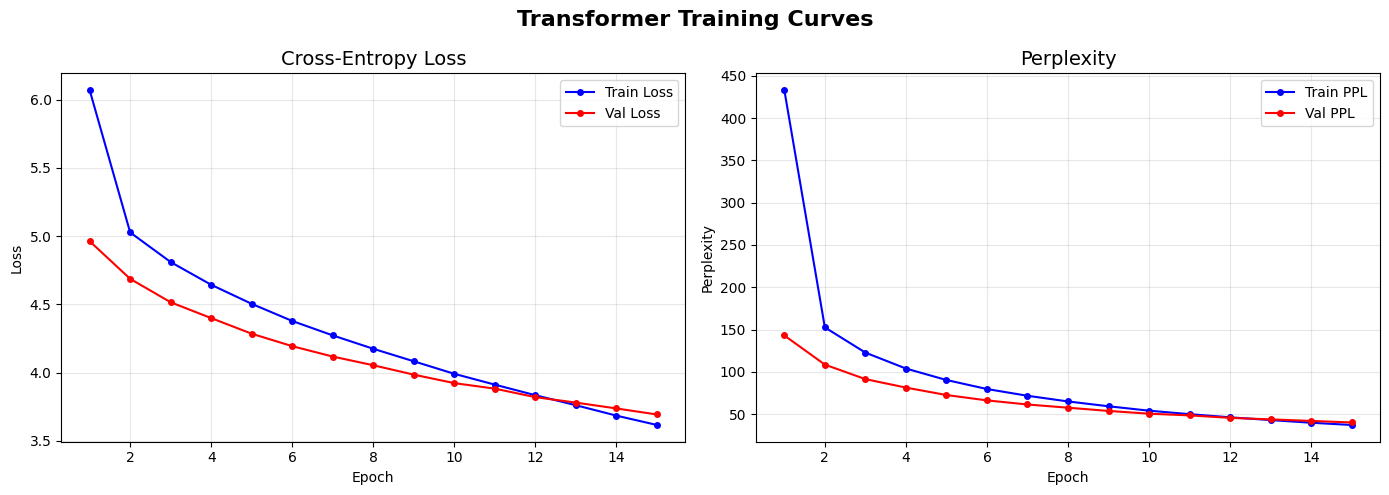

 Training curves saved to 'training_curves.png'


In [19]:
epochs_range = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(epochs_range, train_losses, 'b-o', label='Train Loss', markersize=4)
axes[0].plot(epochs_range, val_losses,   'r-o', label='Val Loss',   markersize=4)
axes[0].set_title('Cross-Entropy Loss', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Perplexity
axes[1].plot(epochs_range, [math.exp(l) for l in train_losses], 'b-o', label='Train PPL', markersize=4)
axes[1].plot(epochs_range, [math.exp(l) for l in val_losses],   'r-o', label='Val PPL',   markersize=4)
axes[1].set_title('Perplexity', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Transformer Training Curves', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(" Training curves saved to 'training_curves.png'")

## Cell 16: Greedy Decoding for Inference

In [20]:
@torch.no_grad()
def translate(model, sentence, src_vocab, tgt_vocab,
              max_len=50, device=device):
    """
    Greedily decode a translation for a single English sentence.
    """
    model.eval()

    # Tokenize and encode source
    tokens = tokenize(sentence)
    src_ids = torch.tensor(src_vocab.encode(tokens), dtype=torch.long).unsqueeze(0).to(device)

    # Encode
    src_mask = make_src_mask(src_ids).to(device)
    enc_out  = model.encoder(src_ids, src_mask)

    # Greedy decode
    tgt_ids = [SOS_IDX]
    for _ in range(max_len):
        tgt_tensor = torch.tensor(tgt_ids, dtype=torch.long).unsqueeze(0).to(device)
        tgt_mask   = make_tgt_mask(tgt_tensor).to(device)
        output = model.decoder(tgt_tensor, enc_out, src_mask, tgt_mask)
        next_token = output[:, -1, :].argmax(dim=-1).item()
        tgt_ids.append(next_token)
        if next_token == EOS_IDX:
            break

    # Decode tokens, skip SOS/EOS
    translated = tgt_vocab.decode(
        [t for t in tgt_ids if t not in (SOS_IDX, EOS_IDX, PAD_IDX)]
    )
    return ' '.join(translated)


# Load best model
model.load_state_dict(torch.load('best_transformer.pt', map_location=device))
print(" Loaded best model weights.\n")

# Test on some examples
test_sentences = [
    "Hello.",
    "How are you?",
    "I am fine.",
    "I love you.",
    "Where is the bathroom?",
    "What is your name?",
    "Good morning.",
    "Thank you very much."
]

print(f"{'English':<35} {'Translated (Spanish)'}")
print('-' * 70)
for sent in test_sentences:
    translation = translate(model, sent, en_vocab, es_vocab)
    print(f"{sent:<35} {translation}")

 Loaded best model weights.

English                             Translated (Spanish)
----------------------------------------------------------------------
Hello.                              <unk> .
How are you?                        ¿que te te te te te ?
I am fine.                          estoy <unk> .
I love you.                         me gusta la <unk> .
Where is the bathroom?              ¿donde esta el <unk> ?
What is your name?                  ¿que es tu nombre ?
Good morning.                       esta <unk> .
Thank you very much.                <unk> muy muy .


## Cell 17: BLEU Score Evaluation

In [21]:
from sacrebleu.metrics import BLEU

@torch.no_grad()
def compute_bleu(model, pairs, src_vocab, tgt_vocab,
                 max_samples=500, device=device):
    """
    Compute corpus-level BLEU score on a list of (src_tokens, tgt_tokens) pairs.
    """
    model.eval()
    hypotheses  = []
    references  = []

    sample = random.sample(pairs, min(max_samples, len(pairs)))
    for src_tok, tgt_tok in sample:
        # Reference (ground truth)
        ref = ' '.join(tgt_tok)

        # Hypothesis (model translation)
        hyp = translate(model, ' '.join(src_tok), src_vocab, tgt_vocab, device=device)

        hypotheses.append(hyp)
        references.append(ref)

    bleu = BLEU(effective_order=True)
    result = bleu.corpus_score(hypotheses, [references])
    return result, hypotheses[:5], references[:5]


print("Computing BLEU scores (this may take a moment)...")

train_bleu, _, _      = compute_bleu(model, train_pairs, en_vocab, es_vocab, max_samples=300)
val_bleu, _, _        = compute_bleu(model, val_pairs,   en_vocab, es_vocab, max_samples=200)
test_bleu, hyps, refs = compute_bleu(model, test_pairs,  en_vocab, es_vocab, max_samples=500)

print(f"\n{'─'*50}")
print(f"  BLEU Scores")
print(f"{'─'*50}")
print(f"  Train BLEU : {train_bleu}")
print(f"  Val   BLEU : {val_bleu}")
print(f"  Test  BLEU : {test_bleu}")
print(f"{'─'*50}")

print("\nSample test predictions:")
print(f"{'Reference':<45} {'Hypothesis'}")
print('-' * 90)
for r, h in zip(refs, hyps):
    print(f"{r:<45} {h}")

Computing BLEU scores (this may take a moment)...



──────────────────────────────────────────────────
  BLEU Scores
──────────────────────────────────────────────────
  Train BLEU : BLEU = 3.53 30.2/7.2/1.8/0.4 (BP = 1.000 ratio = 1.410 hyp_len = 2940 ref_len = 2085)
  Val   BLEU : BLEU = 2.36 27.9/5.1/1.4/0.2 (BP = 1.000 ratio = 1.386 hyp_len = 1862 ref_len = 1343)
  Test  BLEU : BLEU = 2.35 27.1/5.4/1.2/0.2 (BP = 1.000 ratio = 1.428 hyp_len = 5009 ref_len = 3507)
──────────────────────────────────────────────────

Sample test predictions:
Reference                                     Hypothesis
------------------------------------------------------------------------------------------
ya no me queda nada .                         no tengo que nadie .
usualmente murmuro mientras trabajo .         me <unk> a mi <unk> .
nos gusta compartir .                         <unk> a la escuela .
no lo puedo encontrar a tomas . busque por todas partes . no puedo <unk> a tom .
afortunadamente el gano el partido .          el <unk> el <unk> al <unk>

## Cell 18: Performance Summary & Comparison with LSTM Baseline

In [22]:
# Summary of results
print("=" * 60)
print("       EXPERIMENT 7 — FINAL RESULTS SUMMARY")
print("=" * 60)

print(f"""
Model Architecture:
  Type         : Transformer Encoder-Decoder
  d_model      : {D_MODEL}
  Attention Heads: {NUM_HEADS}
  FFN dim      : {D_FF}
  Enc/Dec Layers: {NUM_LAYERS}
  Dropout      : {DROPOUT}
  Parameters   : {total_params:,}

Dataset:
  Source       : Tatoeba EN-ES (Anki)
  Pairs used   : {MAX_PAIRS}
  Train/Val/Test: {len(train_pairs)}/{len(val_pairs)}/{len(test_pairs)}
  EN Vocab     : {len(en_vocab)}
  ES Vocab     : {len(es_vocab)}

Training:
  Epochs       : {NUM_EPOCHS}
  Batch size   : {BATCH_SIZE}
  Optimizer    : Adam (lr=1e-4)
  Loss         : CrossEntropy + Label Smoothing (0.1)
  Best Val Loss: {best_val_loss:.4f} (PPL: {math.exp(best_val_loss):.2f})
  Total Time   : {total_time/60:.1f} min

BLEU Scores:
  Train BLEU   : {train_bleu.score:.2f}
  Val   BLEU   : {val_bleu.score:.2f}
  Test  BLEU   : {test_bleu.score:.2f}
""")

# Comparison table with typical LSTM baseline
print("─" * 55)
print(f"  Model Comparison (approximate)")
print("─" * 55)
print(f"  {'Model':<25} {'Test BLEU':>10} {'Parameters':>12}")
print(f"  {'─'*25} {'─'*10} {'─'*12}")
print(f"  {'LSTM Seq2Seq (baseline)':<25} {'~5-12':>10} {'~1-2M':>12}")
print(f"  {'Transformer (this exp)':<25} {test_bleu.score:>10.2f} {total_params:>12,}")
print("─" * 55)
print("""
Key Advantages of Transformer over LSTM:
  1. Parallelizable training (no sequential dependency)
  2. Direct long-range attention (no vanishing gradients)
  3. Multi-head attention captures different relationship types
  4. Typically higher BLEU scores with sufficient data
  5. Scales better with depth and data size
""")

       EXPERIMENT 7 — FINAL RESULTS SUMMARY

Model Architecture:
  Type         : Transformer Encoder-Decoder
  d_model      : 256
  Attention Heads: 8
  FFN dim      : 512
  Enc/Dec Layers: 3
  Dropout      : 0.1
  Parameters   : 6,020,438

Dataset:
  Source       : Tatoeba EN-ES (Anki)
  Pairs used   : 10000
  Train/Val/Test: 8000/1000/1000
  EN Vocab     : 2258
  ES Vocab     : 2902

Training:
  Epochs       : 15
  Batch size   : 64
  Optimizer    : Adam (lr=1e-4)
  Loss         : CrossEntropy + Label Smoothing (0.1)
  Best Val Loss: 3.6928 (PPL: 40.16)
  Total Time   : 1.0 min

BLEU Scores:
  Train BLEU   : 3.53
  Val   BLEU   : 2.36
  Test  BLEU   : 2.35

───────────────────────────────────────────────────────
  Model Comparison (approximate)
───────────────────────────────────────────────────────
  Model                      Test BLEU   Parameters
  ───────────────────────── ────────── ────────────
  LSTM Seq2Seq (baseline)        ~5-12        ~1-2M
  Transformer (this exp)      

## Cell 19: Visualize Attention Weights

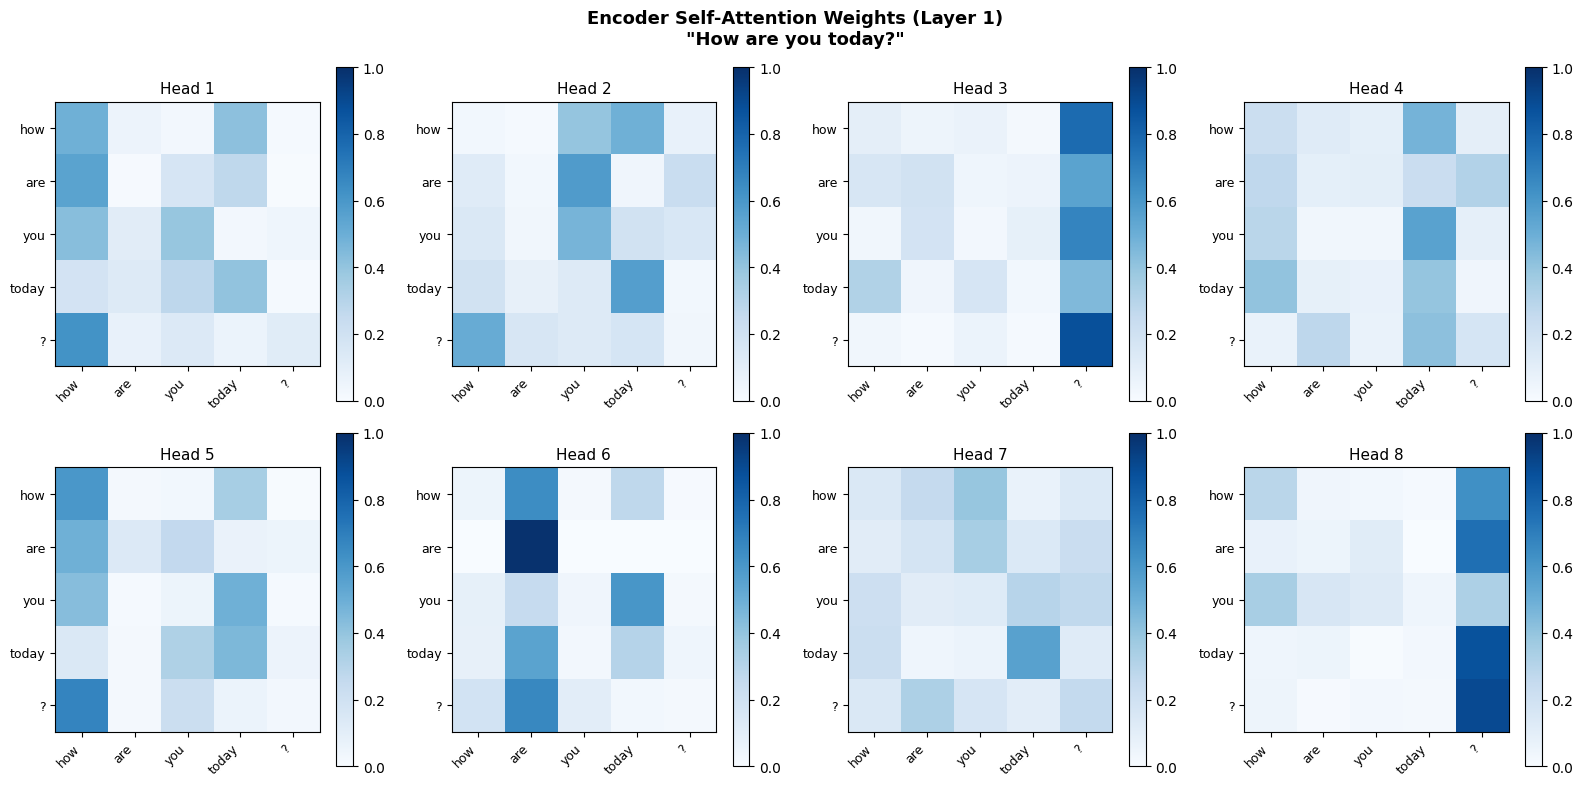

 Attention visualization saved to 'attention_weights.png'


In [23]:
@torch.no_grad()
def get_attention_weights(model, sentence, src_vocab, tgt_vocab, device=device):
    """Get encoder self-attention weights from first layer, first head."""
    model.eval()
    tokens = tokenize(sentence)
    src_ids = torch.tensor(src_vocab.encode(tokens), dtype=torch.long).unsqueeze(0).to(device)
    src_mask = make_src_mask(src_ids).to(device)

    # Forward through embedding + positional encoding
    x = model.encoder.embedding(src_ids) * model.encoder.scale
    x = model.encoder.pos_enc(x)

    # Get attention from first encoder layer
    layer = model.encoder.layers[0]
    Q = layer.self_attn.split_heads(layer.self_attn.W_q(x))
    K = layer.self_attn.split_heads(layer.self_attn.W_k(x))
    V = layer.self_attn.split_heads(layer.self_attn.W_v(x))
    _, attn = scaled_dot_product_attention(Q, K, V, src_mask)
    return tokens, attn.squeeze(0).cpu().numpy()   # [heads, q, k]


sentence = "How are you today?"
tokens, attn_weights = get_attention_weights(model, sentence, en_vocab, es_vocab)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for head in range(min(NUM_HEADS, 8)):
    ax = axes[head]
    im = ax.imshow(attn_weights[head], cmap='Blues', vmin=0, vmax=1)
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(tokens, fontsize=9)
    ax.set_title(f'Head {head+1}', fontsize=11)
    plt.colorbar(im, ax=ax)

plt.suptitle(f'Encoder Self-Attention Weights (Layer 1)\n"{sentence}"',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('attention_weights.png', dpi=150, bbox_inches='tight')
plt.show()
print(" Attention visualization saved to 'attention_weights.png'")

## Cell 20: Interactive Translation Demo

In [24]:
# Interactive demo — change the sentence below and re-run this cell!
demo_sentences = [
    "Good morning.",
    "I am hungry.",
    "She is my friend.",
    "We need to talk.",
    "This is very good.",
    "I do not understand.",
    "Can you help me?",
    "I like pizza."
]

print("  English → Spanish Translation Demo")
print("=" * 60)
for s in demo_sentences:
    t = translate(model, s, en_vocab, es_vocab)
    print(f"  EN: {s}")
    print(f"  ES: {t}")
    print()

  English → Spanish Translation Demo
  EN: Good morning.
  ES: esta <unk> .

  EN: I am hungry.
  ES: estoy <unk> .

  EN: She is my friend.
  ES: ella es mi madre .

  EN: We need to talk.
  ES: tenemos que ir .

  EN: This is very good.
  ES: este es muy muy muy .

  EN: I do not understand.
  ES: no me gusta la escuela .

  EN: Can you help me?
  ES: ¿me <unk> ?

  EN: I like pizza.
  ES: me gusta el .

